In [1]:
#dependencies
import requests
import os
import pandas as pd
import statistics
from pandas import Series
from matplotlib import pyplot as plt
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
import numpy
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.ar_model import ARResults

  

In [2]:
kind = 'CO'
state =  "WV"
choice = "../Data/pollution.csv"

In [3]:
choice_df = pd.read_csv(choice)

In [4]:
index = choice_df.Year.unique()
lst = choice_df[choice_df['State']==state][kind].values

In [5]:
series = pd.Series(lst, index = index)

1999.0    3.300000
2000.0    5.166667
2001.0    4.266667
2002.0    6.100000
2003.0    5.166667
dtype: float64


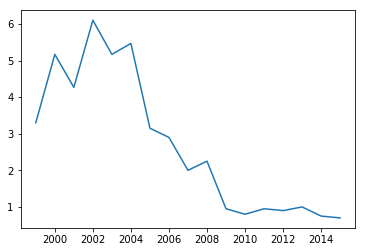

In [6]:
print(series.head())
series.plot()
plt.show()

Test MSE: 0.157


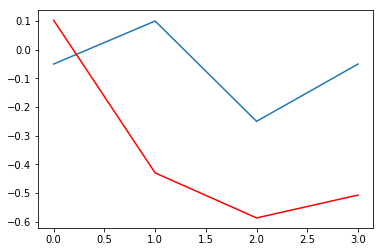

In [7]:

 
# create a difference transform of the dataset
def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return numpy.array(diff)
 
# Make a prediction give regression coefficients and lag obs
def predict(coef, history):
	yhat = coef[0]
	for i in range(1, len(coef)):
		yhat += coef[i] * history[-i]
	return yhat
 

# split dataset
X = difference(series.values)
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:]
# train autoregression
model = AR(train)
model_fit = model.fit(maxlag=3, disp=True)
window = model_fit.k_ar
coef = model_fit.params
# walk forward over time steps in test
history = [train[i] for i in range(len(train))]
predictions = list()
for t in range(len(test)):
	yhat = predict(coef, history)
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [8]:
 
# create a difference transform of the dataset
def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return numpy.array(diff)
 
# load dataset
X = difference(series.values)
# fit model
model = AR(X)
model_fit = model.fit(maxlag=3, disp=False)
# save model to file
model_fit.save('../Model_Info/ar_model.pkl')
# save the differenced dataset
numpy.save('../Model_Info/ar_data.npy', X)
# save the last ob
numpy.save('../Model_Info/ar_obs.npy', [series.values[-1]])

In [9]:
# load the AR model from file
loaded = ARResults.load('../Model_Info/ar_model.pkl')
print(loaded.params)
data = numpy.load('../Model_Info/ar_data.npy')
print(data)
last_ob = numpy.load('../Model_Info/ar_obs.npy')
print(last_ob)

[-0.39383412  0.1229006   0.21636961 -0.43899337]
[ 1.86666667 -0.9         1.83333333 -0.93333333  0.3        -2.31666667
 -0.25       -0.9         0.25       -1.3        -0.15        0.15
 -0.05        0.1        -0.25       -0.05      ]
[0.7]


In [10]:
# load dataset
X = difference(series.values)
# fit model
window_size = 3
model = AR(X)
model_fit = model.fit(maxlag=window_size, disp=False)
# save coefficients
coef = model_fit.params
numpy.save('../Model_Info/man_model.npy', coef)
# save lag
lag = X[-window_size:]
numpy.save('../Model_Info/man_data.npy', lag)
# save the last ob
numpy.save('../Model_Info/man_obs.npy', [series.values[-1]])

In [11]:

coef = numpy.load('../Model_Info/man_model.npy')
lag = numpy.load('../Model_Info/man_data.npy')
last_ob = numpy.load('../Model_Info/man_obs.npy')


In [12]:
prediction_X = [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
yhat = []
for prediction in prediction_X:
    import numpy
    def predict(coef, history):
        yhat = coef[0]
        for i in range(1, len(coef)):
            yhat += coef[i] * history[-i]
        return yhat

    # load model
    coef = numpy.load('../Model_Info/man_model.npy')
    lag = numpy.load('../Model_Info/man_data.npy')
    last_ob = numpy.load('../Model_Info/man_obs.npy')
    # make prediction
    prediction = predict(coef, lag)
    # transform prediction
    y_predict = prediction + last_ob[0]
    yhat.append(y_predict)
    # get real observation
    observation = prediction
    # update and save differenced observation
    lag = numpy.load('../Model_Info/man_data.npy')
    last_ob = numpy.load('../Model_Info/man_obs.npy')
    diffed = observation - last_ob[0]
    lag = numpy.append(lag[1:], [diffed], axis=0)
    numpy.save('../Model_Info/man_data.npy', lag)
    # update and save real observation
    last_ob[0] = observation
    numpy.save('../Model_Info/man_obs.npy', last_ob)

print(yhat)    

[0.2020291084204826, -0.9401064930340077, -1.0663623618869045, -0.5024576614377485, -0.24429200041056826, -0.5785021994843662, -1.0204340959979774, -1.027627882418168, -0.7374569377099789, -0.5595574073184115]
